**Анализ данных сервиса аренды самокатов**

# Цель исследования

Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

# Загрузка и обзор данных

## Считаем CSV-файлы с данными

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats as st
from sklearn.model_selection import train_test_split

# вывод всех столбцов и строк, независимо от их количества.
pd.set_option('display.max_columns', None)

# отключаем предупреждение
pd.options.mode.chained_assignment = None

In [2]:
try:
    users_go = pd.read_csv(
        r'...\users_go.csv',
    )
    rides_go = pd.read_csv(
        r'...\rides_go.csv'
    )
    subscriptions_go = pd.read_csv(
        r'...\subscriptions_go.csv'
    )
except:
    users_go = pd.read_csv('.../users_go.csv')
    rides_go = pd.read_csv('.../rides_go.csv')
    subscriptions_go = pd.read_csv('.../subscriptions_go.csv')

## Выведем первые строки каждого набора данных

In [3]:
print('Данные по users_go')
display(users_go.head())
print('Данные по rides_go')
display(rides_go.head())
print('Данные по rides_go')
display(subscriptions_go.head())

Данные по users_go


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Данные по rides_go


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Данные по rides_go


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


## Изучим общую информацию о каждом датафрейме

In [4]:
users_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

В представленных датафреймах есть столбцы, которые имеют следующее значение:
```
user_id	- уникальный идентификатор пользователя;
name - имя пользователя;
age - возраст;
city - город;
subscription_type - тип подписки (free, ultra);
distance - расстояние, которое пользователь проехал в текущей сессии (в метрах);
duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
date - дата совершения поездки;
subscription_type - тип подписки;
minute_price - стоимость одной минуты поездки по данной подписке;
start_ride_price - стоимость начала поездки;
subscription_fee - стоимость ежемесячного платежа.
```

</div>

## Вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

После изучения общей информации о данных ясно следующее:

- в столбце *distance, duration* значения можно округлить до одной десятой;
- данные в столбце *subscription_type* предствленны в виде `object`, можно преобразовать в категориальный тип `category`;
- в столбце *date* данные представлены в виде `object`, а должны быть в формате даты;
- количество записей в столбцах датафреймов совпадате, пропуски отсутствуют.

</div>

# Предобработка данных

<div style="background-color:dark; color:#black; text-align:left; padding:2%">
    
Подготовка данных для анализа называется предобработкой. Нужно оценить масштаб найденных проблем и 
устранить их. Предобработка следует принципу GIGO (от англ. garbage in — garbage out, буквально «мусор на входе — мусор на выходе»). Это значит, что при ошибках во входных данных даже правильный алгоритм работы приведёт к неверным результатам. Так же нужно помнить об законе экономии, который называется **Бри́тва О́ккама**. В нем говорится следующее: *Не следует множить сущее без необходимости.* Суть принципа: совершенство должно быть простым. Если какого-то результата можно достичь с привлечением сущностей A, B и C либо другим путём с привлечением A, B, С и D — надо выбирать первый путь. В плане программирования это значит, что не следут создавать промежуточные переменные, которые не пригодяться в дальнейшем.

</div>

## Рассмотрим типы данных в каждом столбце

<div style="background-color:dark; color:#black; text-align:left; padding:2%">
    
Для комфортной работы с данными на этапе предобработки необходимо отформатировать данные в нужный нам тип. В шаге 5.3 мы выяснили, в каких столбцах есть проблемы с форматом данных. Это столбцы: 

- в столбце *distance, duration* значения можно округлить до одной десятой;
- данные в столбце *subscription_type* предствленны в виде `object`, можно преобразовать в категориальный тип `category`;
- в столбце *date* данные представлены в виде `object`, а должны быть в формате даты.

</div>

### Столбцы *distance* и *duration*

In [7]:
# округлим значения distance
rides_go['distance'] = rides_go['distance'].round(1)

# округлим значения duration
rides_go['duration'] = np.ceil(rides_go['duration']).astype(int)

### Столбец *subscription_type*

In [8]:
# используем метод astype
users_go.subscription_type = users_go['subscription_type'].astype('category')
subscriptions_go.subscription_type = subscriptions_go['subscription_type'].astype('category')

### Приведем столбец *date* к типу даты pandas

In [9]:
rides_go.date = pd.to_datetime(rides_go.date)

### Создадим новый столбец с номером месяца на основе столбца *date*

In [10]:
rides_go['month'] = rides_go.date.dt.month

<div style="background-color:dark; color:#black; text-align:left; padding:2%">
    
В дальнейшем по ходу проекта мы будем считать выручку за каждый месяц. Поэтому нужно проверить данные и убедиться, что информация представленна за один год.

</div>

In [11]:
# уникальные значения по дате
rides_go.date.dt.year.nunique()

1

## Проверим наличие пропущенных значений и дубликатов.

### Определим, в каких столбцах есть пропуски


In [12]:
# сохраним количество сырых данных
user_len_stock = users_go.shape[0]
rides_len_stock = rides_go.shape[0]

In [13]:
# количество пропущенных значений, комбинируя 2 метода
print(users_go.isna().sum())
rides_go.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

### Проверим дупликаты

In [14]:
# проверим столбец user_id
users_go[users_go['user_id'].duplicated(keep=False)].sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


In [15]:
# скрытые дупликаты
users_go[users_go['user_id'].duplicated(keep=False)].sort_values(by='user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


In [16]:
# удаляем дупликаты
users_go = users_go.drop_duplicates().reset_index(drop=True)

## Количественные значения

<div style="background-color:dark; color:#black; text-align:left; padding:2%">
    
Изучим столбцы, которые хранят количественные значения. Проверим, обнаружились ли в таких столбцах подозрительные данные.

</div>

In [17]:
# сводная таблица параметров users_go
users_go['age'].apply(['count', 'std', 'min', 'mean', 'median', 'max'])

count     1534.000000
std          4.572367
min         12.000000
mean        24.903520
median      25.000000
max         43.000000
Name: age, dtype: float64

In [18]:
# сводная таблица параметров rides_go
(rides_go[['distance', 'duration']]
.apply(['count', 'std', 'min', 'mean', 'median', 'max'])   
.style.format("{:,.2f}"))

,distance,duration
count,"18,068.00","18,068.00"
std,"1,116.83",6.09
min,0.90,1.00
mean,"3,070.66",18.30
median,"3,133.60",18.00
max,"7,211.00",41.00


<div style="background-color:dark; color:#black; text-align:left; padding:2%">
    
Все параметры датасете *users_go* выглядят адекватно. Очевидно, что проехать 4-7 км за 30 сек физически не реально. Проехать 90см в течении 10 минут вполне возможно, пользователь мог передумать ехать по какой-либо причине. За эту поездку оплата взята и ее нужно учитывать при расчете выручки. Исключим эти результаты из датафрейма.

</div>

## Вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

На этапе предобработки данных исправили следующие моменты:

- в столбце *distance, duration* округлили значения до одной десятой;
- данные в столбце *subscription_type* преобразовали в категориальный тип `category`;
- в столбце *date* данные изменили в формат даты;
- проверили колонку *date* и убедились, что информация представленна за один год;
- исправили 62 дупликата в солбце *iser_id*;
- в столбце *distance, duration* округлили значения до одной десятой.

</div>

# Исследовательский анализ данных

<div style="background-color:dark; color:#black; text-align:left; padding:2%">
    
Исследовательский анализ данных является важным этапом в аналитике, который позволяет лучше понять данные и выявить основные характеристики и закономерности. Опишем и визуализируем общую информацию о пользователях и поездках.

</div>

## Частота встречаемости городов

In [22]:
city_freq = users_go.city.value_counts().sort_values(ascending=True)

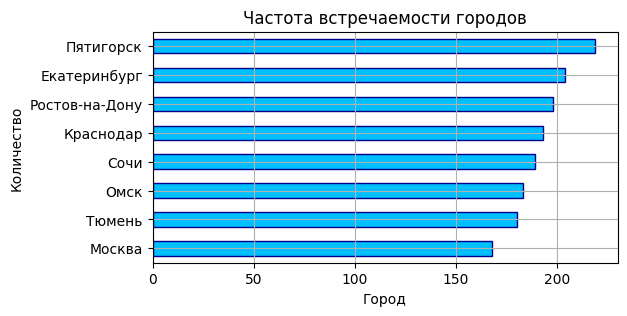

In [23]:
# гистограмма городов
city_freq.plot(y='count_city', figsize=(6, 3), grid=True, kind='barh', color='deepskyblue', edgecolor='darkblue')
plt.title('Частота встречаемости городов')
plt.xlabel('Город')
plt.ylabel('Количество')
plt.show()

## Соотношение пользователей с подпиской и без подписки

In [60]:
# сводная таблица соотношения пользователей
user_ratio = (users_go.groupby('subscription_type', as_index=False, observed=True)
 .agg(count_user = ('user_id', 'count'))
 .set_index('subscription_type')
 .sort_values(by='count_user', ascending=True)
)

# добавим столбец с долей пользователей
user_ratio['decimal, %'] = (
    user_ratio.count_user / user_ratio.count_user.sum() * 100
).round(1)
user_ratio

,count_user,"decimal, %"
subscription_type,,
ultra,699,45.6
free,835,54.4


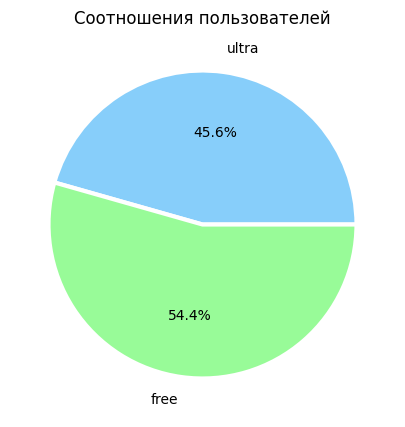

In [27]:
# диаграмма доли пользователей
plt.rcParams["figure.figsize"] = (20,5)
labels = 'ultra', 'free'
colors = ['lightskyblue', 'palegreen']
fig, ax = plt.subplots()
ax.pie(user_ratio['decimal, %'], labels=labels, 
        autopct='%1.1f%%', labeldistance=1.15, 
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
        colors=colors)
plt.title('Соотношения пользователей')
plt.show()

## Возраст пользователей

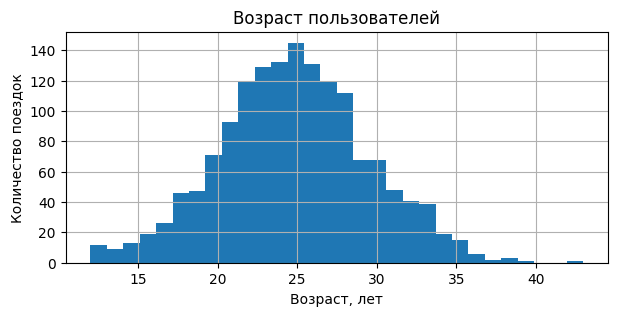

In [28]:
# гистограмма возраста
users_go.age.hist(bins=30, figsize=(7, 3))
plt.title('Возраст пользователей')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество поездок')
plt.show()

## Расстояние поездки

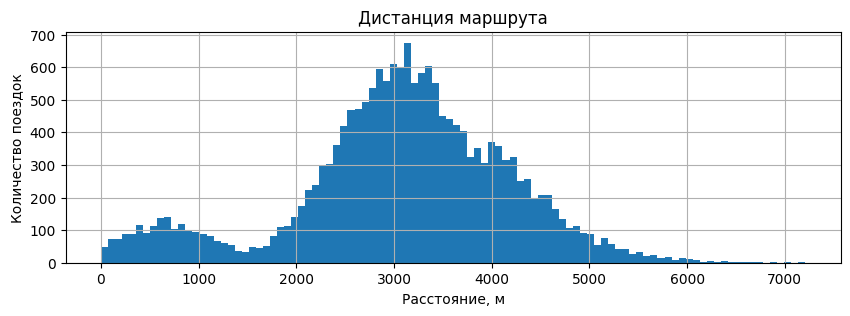

In [29]:
# гистограмма расстояния
rides_go.distance.hist(bins=100, figsize=(10, 3))
plt.title('Дистанция маршрута')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

## Продолжительность поездок

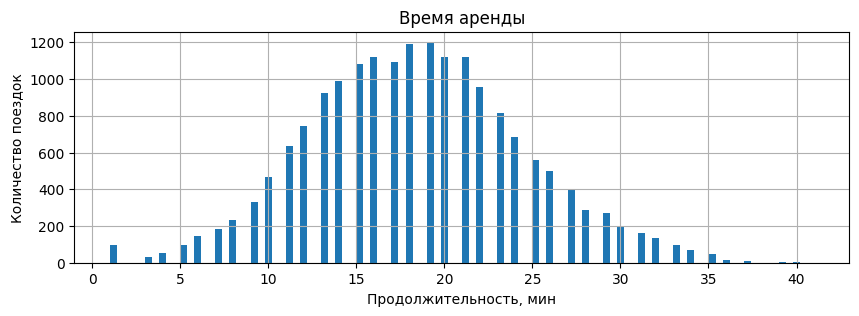

In [30]:
# гистограмма продолжительности
rides_go.duration.hist(bins=100, figsize=(10, 3))
plt.title('Время аренды')
plt.xlabel('Продолжительность, мин')
plt.ylabel('Количество поездок')
plt.show()

## Вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

После проведения исследовательского анализа данных выяснили следующие моменты:

- по разбросу городов следующая статистика лидеров: Пятигорск занимает первое место - 226 раз, Екатеринбург второе - 206 раз, Ростов-на-Дону третье - 202 раза. Худший показатель в Москве - 172 раз;
- по процентному соотношению пользователией с подпиской *free* небольшой перевес - 54.1%, против подписки *ultra* 45.9%;

Слудующие результаты получены в шаге 6.3:

- аренда самокатов популярна у людей в возрасте 25 лет, минимальный возраст - 12 лет, максимальный - 43 года;
- минимальное растояние поездки составляет - 2.6 м, среднее рассnояние 3060 м, максимальное - 7066 м;
- продолжительность поездки, минимальная - 2 мин, средняя - 18 мин, максимальная - 41 мин.

</div>

# Объединение данных 

## Объединим данные

In [31]:
# объединим данные
data = users_go.merge(rides_go, on='user_id', how='inner')
data = data.merge(subscriptions_go, on='subscription_type', how='inner')

In [32]:
# проверим пропуски
data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [33]:
print(f'Длинна исходного кадра {rides_go.shape[0]}')
print(f'Длинна нового кадра {data.shape[0]}')

Длинна исходного кадра 18068
Длинна нового кадра 18068


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

После бъединения данных о пользователях пропуски отсутствуют и количество строк в новом датафрейме совпадает с исходным.

</div>

## Два датафрейма из data

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Создадим ещё два датафрейма из датафрейма, созданного на этапе 8.1:

- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

</div>

### Датафрейм user_free

In [34]:
# филдьрация методом query
user_free = data.query('subscription_type == "free"')

### Датафрейм user_ultra

In [35]:
# филдьрация методом query
user_ultra = data.query('subscription_type == "ultra"')

## Визуализация расстояния и времени поездок

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий с помощью библиотеки `matplotlib`

</div>

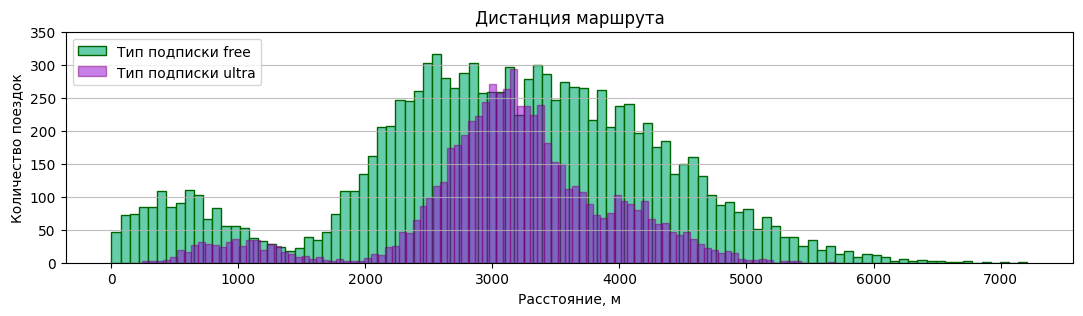

In [36]:
# визуализация расстояния
rcParams['figure.figsize'] = 13, 3
plt.hist(user_free.distance, bins=100, color='mediumaquamarine', edgecolor='darkgreen')
plt.hist(user_ultra.distance, bins=100, color='darkviolet', edgecolor='purple', alpha=.5)
plt.legend(['Тип подписки free', 'Тип подписки ultra'], loc='upper left')
plt.ylim(0, 350)
plt.grid(axis='y', alpha=.8)
plt.title('Дистанция маршрута')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

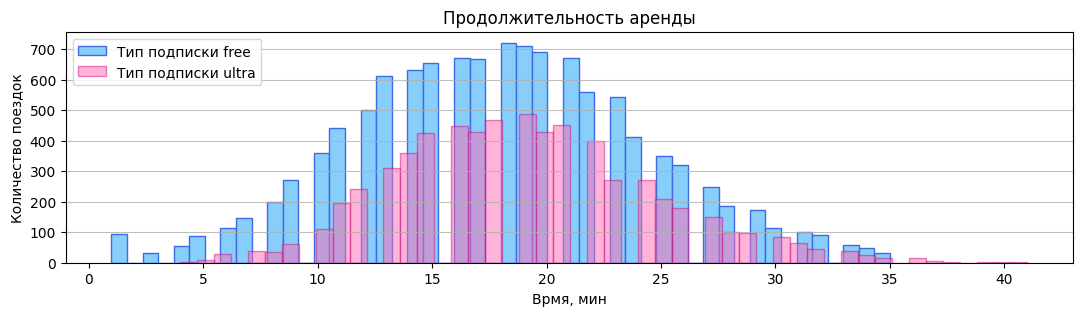

In [37]:
# визуализация времени
rcParams['figure.figsize'] = 13, 3
plt.hist(user_free.duration, bins=50, color='lightskyblue', edgecolor='royalblue')
plt.hist(user_ultra.duration, bins=50, color='hotpink', edgecolor='mediumvioletred', alpha=.5)
plt.legend(['Тип подписки free', 'Тип подписки ultra'], loc='upper left')
plt.grid(axis='y', alpha=.8)
plt.title('Продолжительность аренды')
plt.xlabel('Врмя, мин')
plt.ylabel('Количество поездок')
plt.show()

## Вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

При бъединении данных о пользователях пропуски отсутствуют и количество строк в новом датафрейме совпадает с исходным. Также после объединения данных и визуализации понятно, что пользователи с подпиской *free* ездят дальше и дольше.

</div>

# Подсчёт выручки

## Агрегация данных

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Создадим датафрейм с агрегированными данными о поездках

</div>

In [40]:
# сводная таблица
agg_data_rev = (
    data
    .groupby(['user_id', 'month'], as_index=False)
    .agg({
        'subscription_type' : 'first',
        'duration' : 'sum', 'distance' : 'sum',
        'date' : 'count'
    })
    .set_index('user_id')
    .rename(columns={'date' : 'number_trips'})
    )

# добавляем данные о тарифах
agg_data_rev = agg_data_rev.merge(subscriptions_go, on='subscription_type')

# именуем столбец с индексами
agg_data_rev.index.name = 'user_id'

In [68]:
display(agg_data_rev.head())

,month,subscription_type,duration,distance,number_trips,minute_price,start_ride_price,subscription_fee,revenue
user_id,,,,,,,,,
0,1,ultra,42,7027.5,2,6,0,199,451
1,4,ultra,7,754.2,1,6,0,199,241
2,8,ultra,46,6723.5,2,6,0,199,475
3,10,ultra,32,5809.9,2,6,0,199,391
4,11,ultra,56,7003.5,3,6,0,199,535


## Месячная выручка

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

</div>

In [47]:
# добавим столбец
agg_data_rev['revenue'] = ((agg_data_rev.start_ride_price * agg_data_rev.number_trips) + 
                           (agg_data_rev.minute_price * agg_data_rev.duration) + 
                           agg_data_rev.subscription_fee)

# выручка по группам
revenu_free = agg_data_rev.query('subscription_type == "free"').revenue
revenu_ultra = agg_data_rev.query('subscription_type == "ultra"').revenue

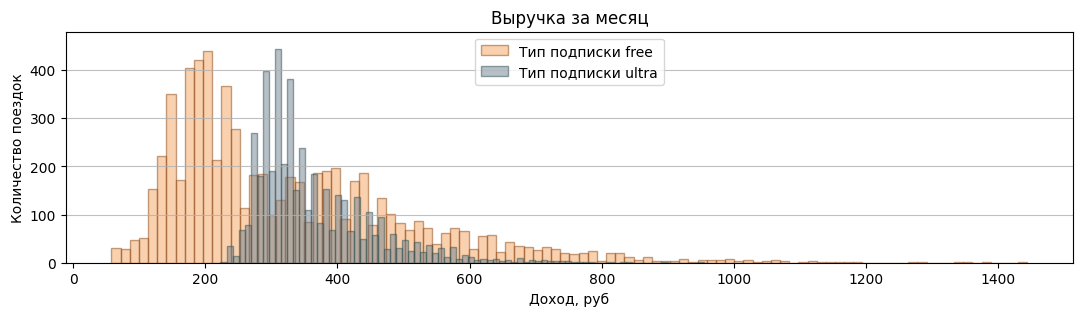

In [48]:
# визуализация выручки
rcParams['figure.figsize'] = 13, 3
plt.hist(revenu_free, bins=100, color='sandybrown', edgecolor='saddlebrown', alpha=.5)
plt.hist(revenu_ultra, bins=80, color='slategray', edgecolor='darkslategray', alpha=.5)
plt.legend(['Тип подписки free', 'Тип подписки ultra'], loc='upper center')
plt.ylim(0, 480)
plt.grid(axis='y', alpha=.8)
plt.title('Выручка за месяц')
plt.xlabel('Доход, руб')
plt.ylabel('Количество поездок')
plt.show()

In [49]:
print(f'Общая без подписки {revenu_free.sum()}')
print(f'Общая с подпиской {revenu_ultra.sum()}')
print(f'Разница в процентах {(((revenu_free.sum()/revenu_ultra.sum())-1)*100).round(1)}')

Общая без подписки 2234104
Общая с подпиской 1644537
Разница в процентах 35.9


## Вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

После агрегации и визуализации понятно, что пользователи с подпиской *free* принесли общий доход на 35.9% выше, так как их количество больше, по сравнению с подписчиками.

</div>

# Проверка гипотез

## Гипотеза о средней продолжительности сессии 

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Важно понять, тратят ли пользователи с подпиской больше времени на поездки?
</div>

In [50]:
print(f'Среднее время на поездку без подписки: {user_free.duration.mean().round(1)}')
print(f'Среднее время на поездку подписчиков: {user_ultra.duration.mean().round(1)}')

Среднее время на поездку без подписки: 17.9
Среднее время на поездку подписчиков: 19.0


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Очевидно, что ользователи с подпиской тратят больше времени на поездки. Поэтому они «выгоднее» для компании. Допустим, разность между средними отличается от нуля, но как понять, что это отличие значимо? Проверим это утверждение с помощью статистического теста и библиотеки `scipy`. 

Сформулируем нулевую гипотезу так: 
- среднее значение времени на поездку пользователей с подпиской равно среднему значению времени на поездку без подписки.

Альтернативная гипотеза: 
- среднее значение времени на поездку пользователей с подпиской больше, чем среднее значение времени на поездку без подписки.

</div>

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Чтобы проверить альтернативную гипотезу, используем метод `ttest_ind()`. В качестве `alternative` нужно указать `greater`, то есть «больше».

</div>

In [52]:
# задаём уровень значимости
alpha = 0.05

# проводим тест, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(
    user_ultra.duration, 
    user_free.duration, 
    equal_var=False, 
    alternative='greater'
)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

С помощью теста мы отвергли нулевую гипотезу о равенстве времени поездки пользователей с подпиской и без в сторону альтернативной.

</div>

## Расстояние одной поездки

In [53]:
user_ultra.distance.mean()

3115.4449846153843

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м, это утверждение верно. Проверим гипотезу с помощью статистического теста.

Сформулируем нулевую гипотезу так: 
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 м.

Альтернативная гипотеза: 
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку больше 3130 м.

</div>

In [54]:
# оптимальное с точки зрения износа
interested_value = 3130

# уровень статистической значимости
alpha = 0.05

# проводим правостороннии тест, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_1samp(user_ultra.distance, interested_value, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195427368335853
Нет оснований отвергнуть нулевую гипотезу


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

С помощью теста мы подтвердили нулевую гипотезу

</div>

## Месячный доход по категориям

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Проверим гипотезу о том, будет ли месячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

</div>

In [56]:
print(f'Средний месячный доход без подписки: {revenu_free.mean()}')
print(f'Средний месячный доход подписчиков: {revenu_ultra.mean()}')

Средний месячный доход без подписки: 328.6413651073845
Средний месячный доход подписчиков: 362.7921906022502


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

Очевидно, что пользователи с подпиской приносят больший доход от поездок в месяц. Проверим это утверждение с помощью статистического теста. 

Сформулируем нулевую гипотезу так: 
- средняя выручка от пользователей с подпиской равна, выручке от пользователей без подписки.

Альтернативная гипотеза: 
- средняя выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

</div>

In [57]:
# задаём уровень значимости
alpha = 0.05

# проводим тест, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(revenu_ultra, revenu_free, equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


<div style="background-color:dark; color:#black; text-align:left; padding:2%">

С помощью теста мы отвергли нулевую гипотезу о равенстве выручки от пользователей с подпиской и без, в сторону альтернативно гипотезы.

</div>

## Вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

После проверки гипотез ясно следующее:

- отвергли нулевую гипотезу о равенстве времени поездки пользователей с подпиской и без. Тем самым подтвердили, что среднее значение времени на поездку пользователей с подпиской больше, чем среднее значение времени на поездку без подписки;
- подтвердили оптимальное расстояние поездки для износа самоката - 3130 м;
- отвергли нулевую гипотезу о равенстве выручки от пользователей с подпиской и без, тем самым подтвердили, что средняя выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки в месяц.

</div>

# Общий вывод

<div style="background-color:dark; color:#black; text-align:left; padding:2%">

В данном исследовании мы провели предобработку данных, проанализировали информацию о пользователях сервиса проката самокатов и проверили некоторые гипотезы, которые могут помочь бизнесу вырасти.

После изучения общей информации о данных ясно следующее:

- в столбце *distance, duration* значения округлили до одной десятой;
- данные в столбце *subscription_type* предствленны в виде `object`, преобразовали их в категориальный тип `category`;
- в столбце *date* данные представлены в виде `object`, изменили в формат даты;
- количество записей в столбцах датафреймов совпадате, пропуски отсутствуют.

На этапе предобработки данных исправили следующие моменты:

- в столбце *distance, duration* округлили значения до одной десятой;
- данные в столбце *subscription_type* преобразовали в категориальный тип `category`;
- в столбце *date* данные изменили в формат даты;
- проверили колонку *date* и убедились, что информация представленна за один год;
- исправили 62 дупликата в солбце *iser_id*;
- в столбце *distance, duration* округлили значения до одной десятой.

После проведения исследовательского анализа данных выяснили следующие моменты:

- по разбросу и частоте встречаемости городов следующая статистика лидеров: Пятигорск занимает первое место - 226 раз, Екатеринбург второе - 206 раз, Ростов-на-Дону третье - 202 раза. Худший показатель в Москве - 172 раз;
- по процентному соотношению пользователией с подпиской *free* небольшой перевес - 54.1%, против подписки *ultra* 45.9%;
- аренда самокатов популярна у людей в возрасте 25 лет, минимальный возраст - 12 лет, максимальный - 43 года;
- минимальное растояние поездки составляет - 2.6 м, среднее рассnояние 3060 м, максимальное - 7066 м;
- продолжительность поездки, минимальная - 2 мин, средняя - 18 мин, максимальная - 41 мин.

При бъединении данных о пользователях пропуски отсутствуют и количество строк в новом датафрейме совпадает с исходным. Также после объединения данных и визуализации понятно, что пользователи с подпиской *free* ездят дальше и дольше.

После агрегации и визуализации понятно, что пользователи с подпиской *free* принесли доход на 35.9% выше, так как их количество больше, по сравнению с подписчиками.

После проверки гипотез понятно следующее:

- отвергли нулевую гипотезу о равенстве времени поездки пользователей с подпиской и без. Тем самым подтвердили, что среднее значение времени на поездку пользователей с подпиской больше, чем среднее значение времени на поездку без подписки;
- подтвердили оптимальное расстояние поездки для износа самоката - 3130 м;
- отвергли нулевую гипотезу о равенстве выручки от пользователей с подпиской и без, тем самым подтвердили, что средняя выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки в месяц.

</div>

In [58]:
print(f'Средняя выручка в месяц без подписки {revenu_free.mean()}')
print(f'Средняя выручка в месяц с подпиской {revenu_ultra.mean()}')
print(f'Разница в процентах {(((revenu_ultra.mean()/revenu_free.mean())-1)*100).round(1)}')

Средняя выручка в месяц без подписки 328.6413651073845
Средняя выручка в месяц с подпиской 362.7921906022502
Разница в процентах 10.4
